A preliminary draft based on results from Berlin
# Solar radiation nowcasting using a hybrid approach
**Xinyuan Hou**

Supervisor: **Dr. Stelios Kazadzis**

## Table of contents

[Objective](#Objective)

[Data](#Data)

[Model & methods](#Model-&-methods)

[Results](#Results)

## Objective

The objective of this study is to provide infomation about solar radiation availability in the next hour(s) to aid solar power corporations to schedule input distributions. 

## Data

We use radiation data from Copernicus Atmospheric Monitoring Service (CAMS), and compute the Cloud Modification Factor (CMF), defined as the ratio of GHI in all-sky condition to that in clear-sky conditions (GHI_CS):

$$CMF = \frac{GHI}{GHI_{CS}}$$

If CMF approaches 0, the sky is cloudy, while a CMF value of 1 implies it is clear sky without clouds.

We take the time series with an interval of 15 minutes, extending from 01.02.2004 to 31.12.2020. The data on CAMS are updated until two days prior to the instantaneous query time.

We choose four cities of different cloud conditions in Europe: 

City           | Coordinates
:--------------|:------------------
Athens         | 37.98° N, 23.72° E 
Bucharest      | 44.44° N, 26.08° E 
Berlin         | 52.52° N, 13.37° E
Helsinki       | 60.19° N, 24.93° E 

which are in descending order of long-term average CMF.

## Model & methods

### Markov Chain

Solar radiation possesses Markov property, which indicates that the evolution of the Markov process in the future depends only on the present state and does not depend on the past. This property permits to predict solar radiation via a Markov chain (MC) model; in this study we develop and employ a discrete-time MC model.

Firstly, we divide the CMF time series into the period 2004 to 2018 for fitting the transition matrix from historical occurrence (training set), the year 2019 for evaluating the error metrics of the MC model (validation set), and the year 2020 for testing the performance of different prediction approaches (test set), including the implementation of the hybrid approach (see below).

#### State classification

We first classify the CMF values into 30 integer states, each state having the same amount of  data points. Consequently, the lower (higher) ranges of CMF values for each state are not equally spaced, but in larger intervals for smaller CMF values (towards 0) and in smaller intervals at the higher CMF values (towards 1). Firstly, we compute the 30-tiles of the training set as the starts of each bin. Then, we classify the state of each CMF value by comparing it with the start of each bin. We compute the mean CMF value within each class and store these 30 values for later prediction in combination with the transition matrix. 

#### Transition matrix

For the second order Markov chain, we initiate an `n²×n` matrix. The columns represent n possible states for the immediate time step (n=30 in this study), whereas the rows list all `n²` transition cases of states from the previous to the current time step., namely `1→1`, `1→2`, ..., `1→30`, `2→1`, ..., and `30→30`. We count the occurrence of each case to fill into the matrix. After converting the integers to frequencies within each row, we obtain the normalized transition matrix, indicating the frequency of next possible state at a given transition from the previous to the current time step. The sum of a certain row vector might be zero, in this case, the frequency of not a number (`NaN`) is replaced by 0.

#### MC Prediction 

We implement two kinds of Markov chain prediction approaches, noted as Variant a and Variant b.

##### Variant a
From the test set, we take two consecutive values as the observation and compute the value at the next step from the pre-calculated transition matrix. Rather than using random uniform sampling, as employed in some previous studies (#ref), we compute the prediction value by weighted mean at the specific row (transition) in the transition matrix.

##### Variant b
To predict the CMF values longer than two time steps ahead of the current time step, we take two consecutive values from the validation set as the observation and we predict the value for the next time step following variant a. For the prediction of one further time step, the previous two observation points consist of the latter one from the record and the newly predicted one, and we apply the prediction following variant a. If the value at one further time step is needed, the new observation would be the two consecutive predictions. We repeat this procedure until reaching the prediction for four time steps ahead.

### Persistence approach

This approach assumes the cloud state does not change from the previous to the current time step, therefore uses the CMF value at the previous time step as the prediction for the current time step. It is essentially a temporal shift of the original time series by a certain interval, in this case, one time step later.

### Neighbor inference approach

Using Berlin as a test bed, we evaluate the viability of inferring CMF values of the central cell from CMF values of its neighbor cells at the previous time step. The neighbor cells are the central cell shifted to these eight directions by 0.1° longitude or/and latitude: to the west, northwest, north, northeast, east, southeast, south and southwest. We first exclude the time steps with CMF values higher than 0.95 (sunny with very few clouds) and compute the Pearson correlation of CMF values at the central cell with those at the neighbor cells to obtain eight correlation coefficients.

### Hybrid approach

For the time series of 2019, we evaluate the error metrics of persistence method, neighbor inference, MC prediction Variant a and Variant b by mean absolute error (MAE) and root mean square error (RMSE) for all 30 CMF classes. If the error by the certain approach is the smallest among the considered approaches, we adopt this approach for this specific CMF class. We apply this information on the time series of 2020 by choosing the optimal approach for the next time step based on the CMF class at the current time step.

### GHI prediction

For the computation of all-sky GHI, we multiply clear-sky GHI provided by CAMS by predicted CMF values following different approaches: 

$$GHI = GHI_{CS} ∙ CMF$$

## Results

### CMF distribution

Fig. 1 shows the CMF distributions of three data sets for Berlin. The validation and test sets inherit the classification from the training set, thus do not have equal number of data points in every class.

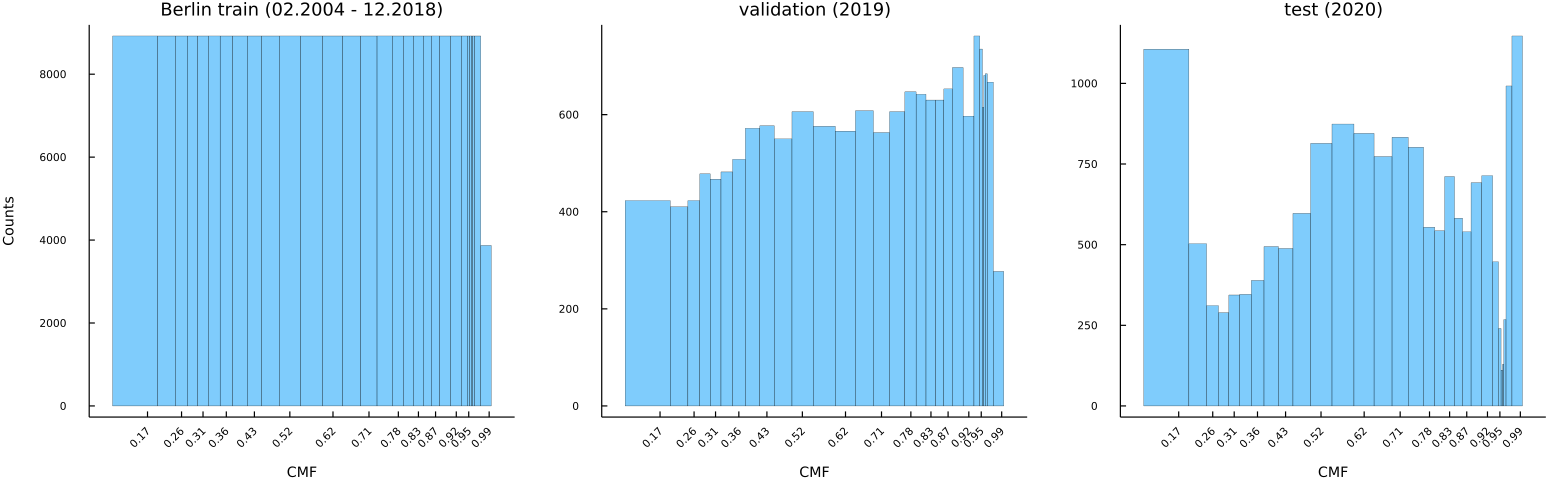

In [66]:
Fig. 1

### Transition matrix

Fig. 2 shows the second order transition matrix, with the x-axis representing the CMF class from two time steps prior and the y-axis one time step prior. The color in each cell denotes the CMF value for the time step to be predicted.

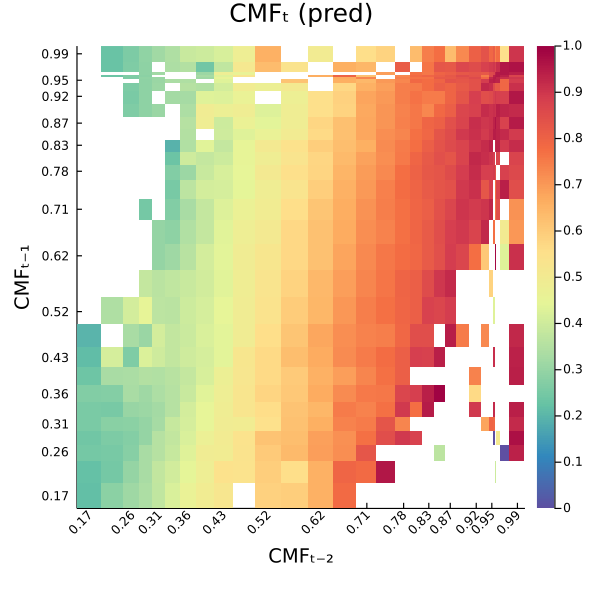

In [38]:
Fig. 2

### Neighbor inference

Fig. 3 shows the correlation coefficients of the CMF values in Berlin with CMF values from the previous time step (15 minutes before) in the eight neighbor cells (based on the time series from 2004 - 2019). Here, we exclude clear-sky states by filtering out CMF values larger than or equal to 0.95. The highest correlation is with the cell to the west, followed by the cells in the northwest and southwest. Moving towards the east, the correlation decreases and the minimum situates in the southeastern cell. This is as expected, since the general movement of clouds above Berlin is westerly flow. 
Next, we evaluate the performance of using prior CMF values from the western cell in comparison to other prediction approaches. 

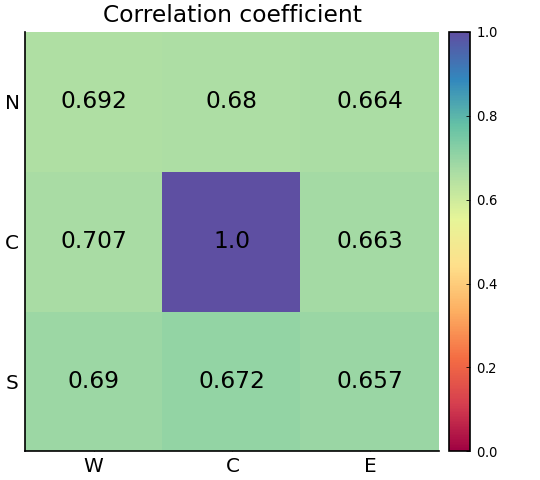

In [43]:
Fig. 3

The following results are all assessments for 2020.
### Mean & standard deviation of bias

In [35]:
Table shows the mean of the bias for different approaches. Rows are the lead time steps, columns are the five analyzed approaches.

,pers,neib,pred,hyb_r,hyb_m
,Float64,Float64,Float64,Float64,Float64
1,0.00164096,0.00726134,0.000200121,0.00889467,0.0102064
2,0.00364794,0.00904476,0.0108197,0.0107881,0.0156444
3,0.00443601,0.0098019,0.0154711,0.0154388,0.0204284
4,0.00407991,0.00952337,0.0151966,0.0151636,0.0198869


In [36]:
Similar to the previous table, but for standard deviation of the bias.

,pers,neib,pred,hyb_r,hyb_m
,Float64,Float64,Float64,Float64,Float64
1,0.113262,0.125779,0.0544481,0.0423039,0.0409061
2,0.1629,0.166922,0.0974879,0.0976313,0.0951683
3,0.185027,0.184363,0.139164,0.139221,0.137234
4,0.199844,0.197804,0.165715,0.165743,0.164424


Fig. 4 is the visualization of the above two tables. While the mean bias is the minimum for the persistence method at each lead time step, the MC prediction and the hybrid approach based on MAE or RMSE have smaller standard deviation of bias than the persistence approach.

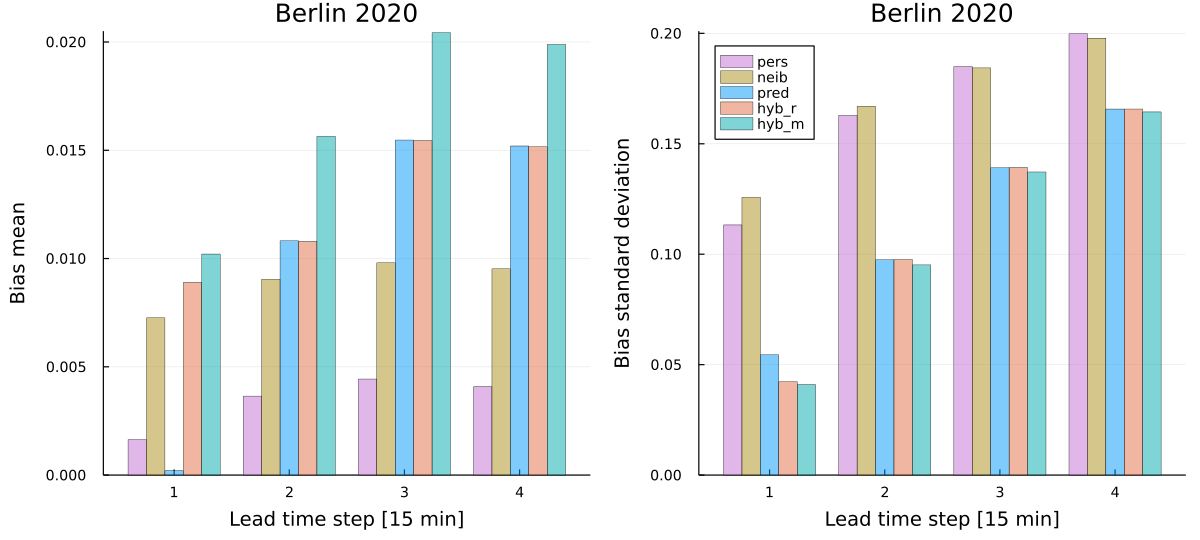

In [132]:
Fig. 4

### MAE versus RMSE

Fig. 5 shows MAE vs RMSE of different methods for 4 time steps from the lower left to upper right. For 15 min ahead, the errors of the hybrid methods are very close. From 30 min ahead on, the errors of the hybrid method based on RMSE are basically the same as of the MC prediction. The errors of the persistence method and the neighbor inference for 15 min ahead are even larger than of the hybrid methods or MC prediction for 30 min ahead.

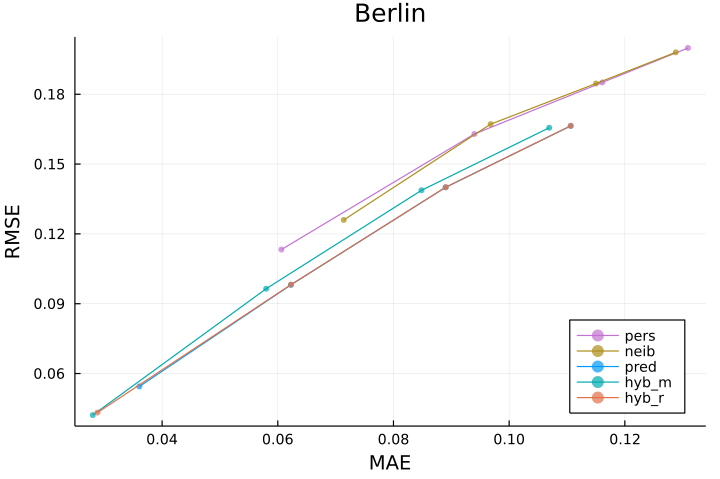

In [195]:
Fig. 5

### GHI prediction

Fig. 6 (Fig. 7) show the monthly MAE (RMSE) of the predicted GHI during the year 2020. In general, the hybrid method based on MAE has the mininum errors, closely followed by the hybrid method based on RMSE and the MC prediction.

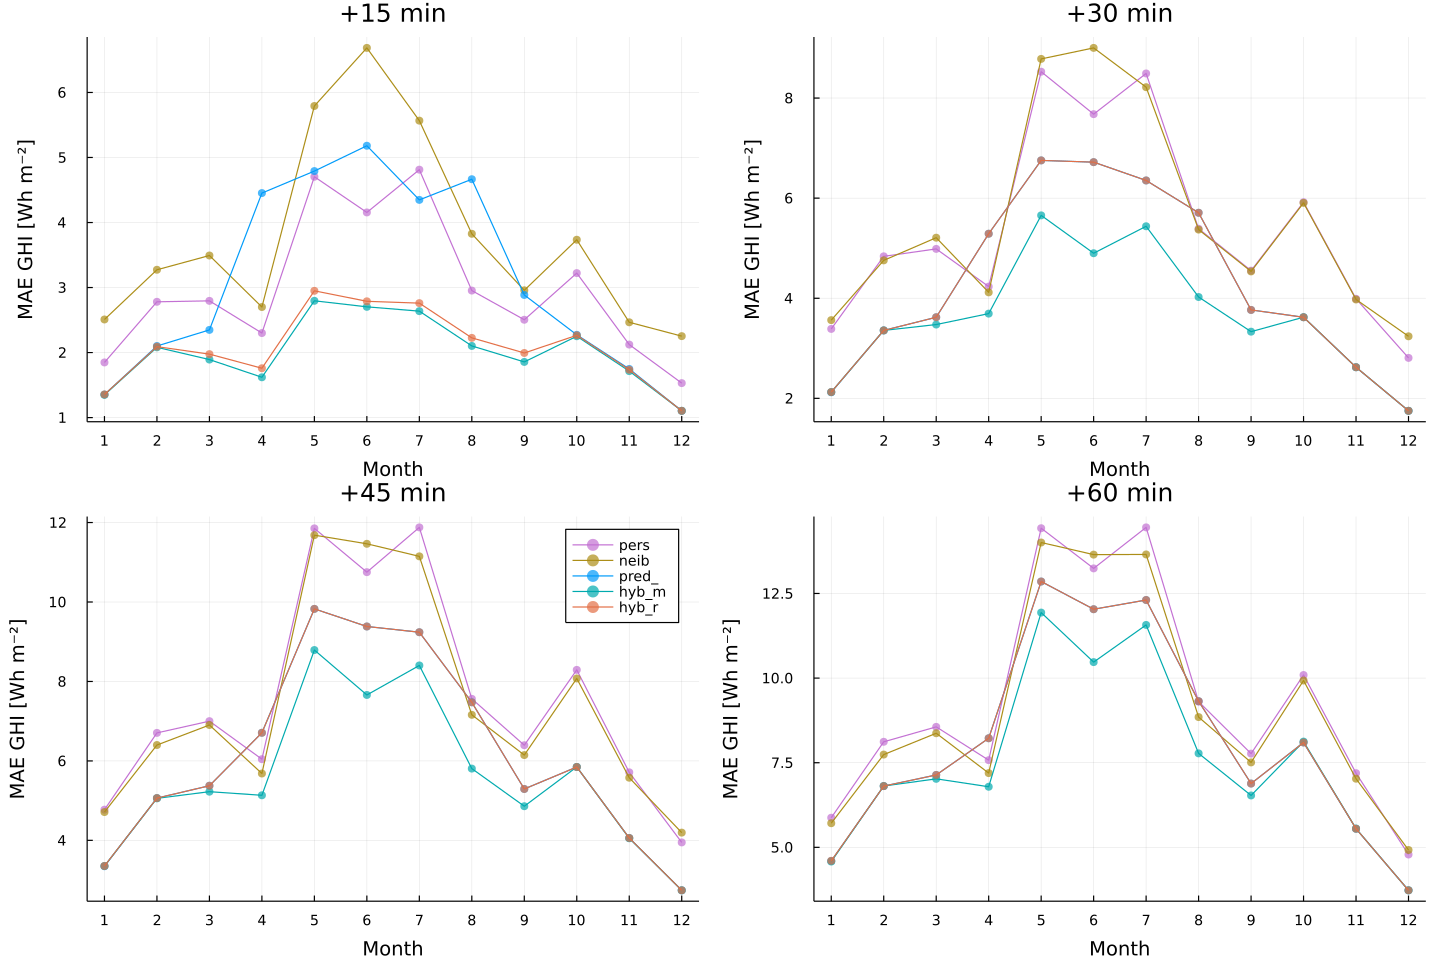

In [50]:
Fig. 6

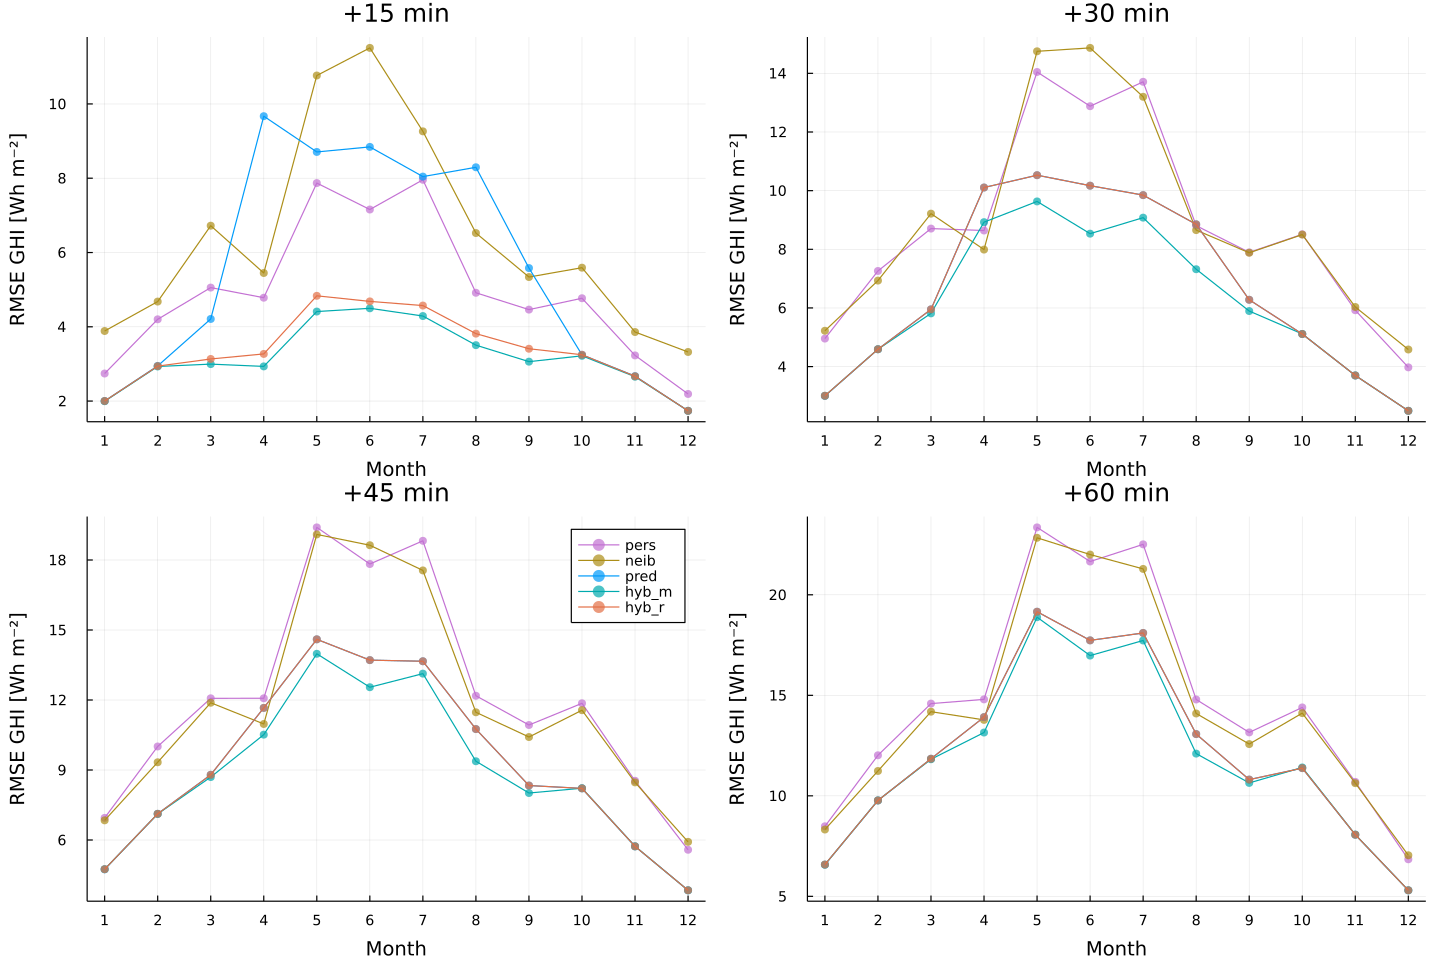

In [54]:
Fig. 7